In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [2]:
train = pd.read_csv("C:\\Users\\Nehal\\Downloads\\new-york-city-taxi-fare-prediction\\train.csv", nrows = 1000000, parse_dates=["pickup_datetime"])
test = pd.read_csv("C:\\Users\\Nehal\\Downloads\\new-york-city-taxi-fare-prediction\\test.csv")

In [5]:
train.drop('key', axis=1, inplace=True)

In [7]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [9]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [10]:
train.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [11]:
train.isna().sum()

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

In [12]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.00000,1000000.00000,1000000.00000,999990.00000,999990.00000,1000000.00000
mean,11.34808,-72.52664,39.92901,-72.52786,39.91995,1.68492
std,9.82209,12.05794,7.62615,11.32449,8.20142,1.32391
min,-44.90000,-3377.68093,-3116.28538,-3383.29661,-3114.33857,0.00000
25%,6.00000,-73.99206,40.73497,-73.99138,40.73405,1.00000
50%,8.50000,-73.98179,40.75270,-73.98014,40.75317,1.00000
75%,12.50000,-73.96709,40.76715,-73.96365,40.76813,2.00000
max,500.00000,2522.27133,2621.62843,45.58162,1651.55343,208.00000


In [13]:
(train['fare_amount'] < 0).sum()

38

In [15]:
((train['pickup_longitude'] < -180) | (train['pickup_longitude'] > 180)).sum()

15

In [16]:
((train['pickup_latitude'] < -90) | (train['pickup_latitude'] > 90)).sum()

12

In [17]:
((train['passenger_count'] == 0) | (train['passenger_count'] > 6)).sum()

3566

In [18]:
(train['passenger_count'] > 6).sum()

1

In [19]:
print("Train Passenger count equals 0: ", (train['passenger_count'] == 0).sum())
print("Test Passenger count equals 0: ", (test['passenger_count'] == 0).sum())

Train Passenger count equals 0:  3565
Test Passenger count equals 0:  0


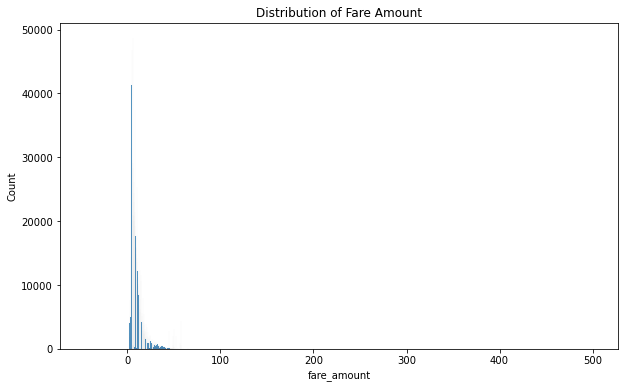

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(train['fare_amount']);
plt.title('Distribution of Fare Amount');

In [21]:
def clean_df(df):
    new_df = df[
        ((df['fare_amount'] > 0) & (df['fare_amount'] <= 200)) &
        ((df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -73)) &  
        ((df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)) &
        ((df['dropoff_longitude'] > -75) & (df['dropoff_longitude'] < -73)) &
        ((df['dropoff_latitude'] > 40 & (df['dropoff_latitude'] < 42))) &
        ((df['passenger_count'] > 0) & (df['passenger_count'] <= 6))
    ]
    
    return new_df

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

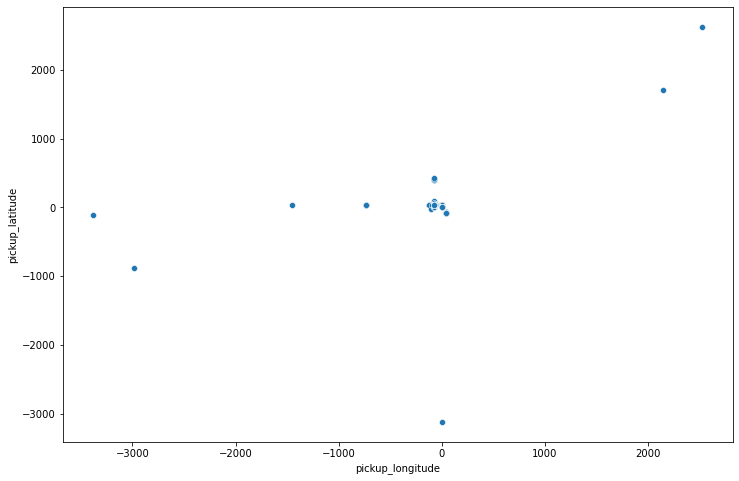

In [23]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=train['pickup_longitude'], y=train['pickup_latitude'])

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

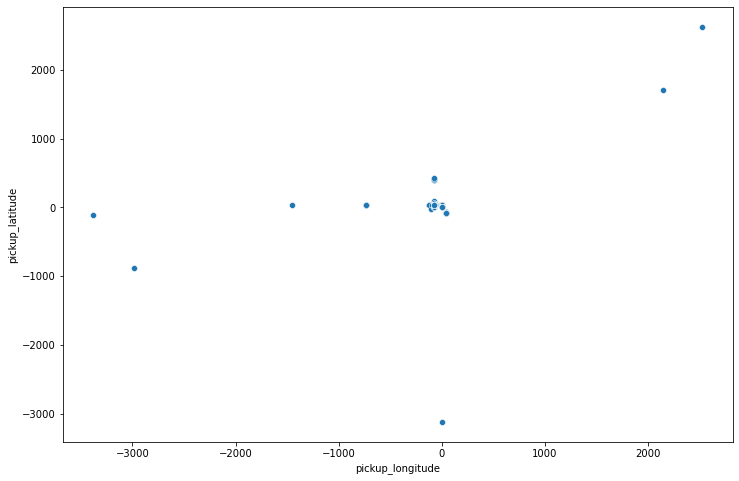

In [24]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=train['pickup_longitude'], y=train['pickup_latitude'])

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

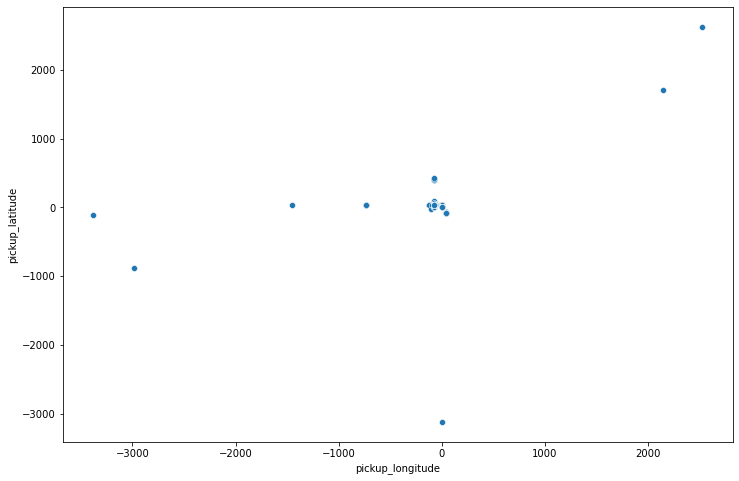

In [25]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=train['pickup_longitude'], y=train['pickup_latitude'])

In [26]:
print("Before:", len(train))
train_df = clean_df(train)
print("After:", len(train))

Before: 1000000
After: 1000000


<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

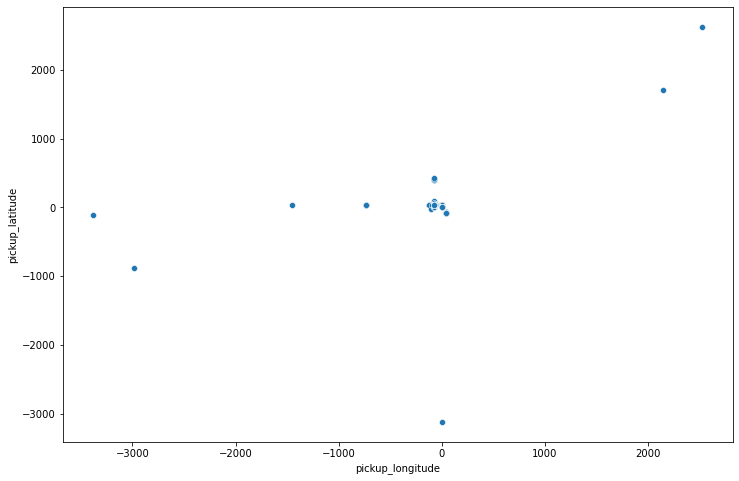

In [27]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=train['pickup_longitude'], y=train['pickup_latitude'])

Text(0, 0.5, 'Fare Amount')

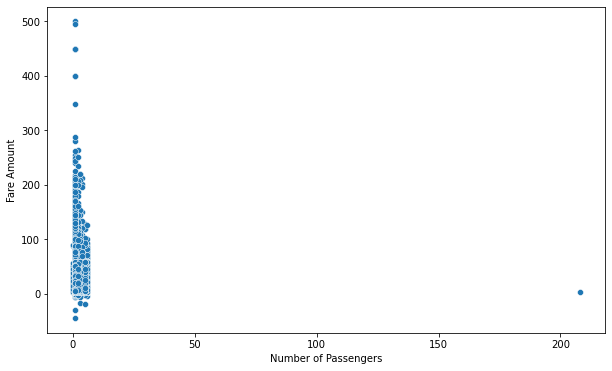

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['passenger_count'], y=train['fare_amount'])
plt.xlabel('Number of Passengers')
plt.ylabel('Fare Amount')

In [29]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.00000,1000000.00000,1000000.00000,999990.00000,999990.00000,1000000.00000
mean,11.34808,-72.52664,39.92901,-72.52786,39.91995,1.68492
std,9.82209,12.05794,7.62615,11.32449,8.20142,1.32391
min,-44.90000,-3377.68093,-3116.28538,-3383.29661,-3114.33857,0.00000
25%,6.00000,-73.99206,40.73497,-73.99138,40.73405,1.00000
50%,8.50000,-73.98179,40.75270,-73.98014,40.75317,1.00000
75%,12.50000,-73.96709,40.76715,-73.96365,40.76813,2.00000
max,500.00000,2522.27133,2621.62843,45.58162,1651.55343,208.00000


In [30]:
def manhattan_dist(lat_p, long_p, lat_d, long_d):  
    distance = np.abs(lat_d - lat_p) + np.abs(long_d - long_p)
    
    return distance

In [31]:
def add_datetime_info(df, transform_datetime=False):
    if transform_datetime:
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
    
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day'] = df['pickup_datetime'].dt.day
    df['month'] = df['pickup_datetime'].dt.month
    df['year'] = df['pickup_datetime'].dt.year
#     df['weekday'] = df['pickup_datetime'].dt.weekday # removing this since it's the least important feature
    df.drop('pickup_datetime', axis=1, inplace=True)

In [32]:
  def add_airport_info(df):
    nyc = (-74.0063889, 40.7141667)
    jfk = (40.6441666667, -73.7822222222)
    ewr = (40.69, -74.175)
    lgr = (40.77, -73.87)
    
    df['distance_to_center'] = manhattan_dist(nyc[0], nyc[1], df['pickup_latitude'], df['pickup_longitude'])
    df['pickup_distance_to_jfk'] = manhattan_dist(jfk[0], jfk[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_jfk'] = manhattan_dist(jfk[0], jfk[1], df['dropoff_latitude'], df['dropoff_longitude'])
    df['pickup_distance_to_ewr'] = manhattan_dist(ewr[0], ewr[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_ewr'] = manhattan_dist(ewr[0], ewr[1],df['dropoff_latitude'], df['dropoff_longitude'])
    df['pickup_distance_to_lgr'] = manhattan_dist(lgr[0], lgr[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_lgr'] = manhattan_dist(lgr[0], lgr[1], df['dropoff_latitude'], df['dropoff_longitude'])

    df['long_diff'] = df.dropoff_longitude - df.pickup_longitude
    df['lat_diff'] = df.dropoff_latitude - df.pickup_latitude

In [33]:
def transform(df, transform_datetime):
    add_datetime_info(df, transform_datetime)
    add_airport_info(df)
    df['manhattan_dist'] = manhattan_dist(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    return df

In [34]:
train_df = transform(train_df, transform_datetime=True)
train_df.head()

<ipython-input-31-d13deee9b0dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
<ipython-input-31-d13deee9b0dd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['pickup_datetime'].dt.hour
<ipython-input-31-d13deee9b0dd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance_to_center,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,long_diff,lat_diff,manhattan_dist
0,4.50000,-73.84431,40.72132,-73.84161,40.71228,1,17,15,6,2009,229.28619,0.13924,0.12750,0.36201,0.35567,0.07437,0.08611,0.00270,-0.00904,0.01174
1,16.90000,-74.01605,40.71130,-73.97927,40.78200,1,16,5,1,2010,229.44791,0.30096,0.33488,0.18026,0.28774,0.20474,0.12127,0.03678,0.07070,0.10748
2,5.70000,-73.98274,40.76127,-73.99124,40.75056,2,0,18,8,2011,229.46456,0.31762,0.31542,0.26353,0.24432,0.12147,0.14068,-0.00850,-0.01071,0.01921
3,7.70000,-73.98713,40.73314,-73.99157,40.75809,1,4,21,4,2012,229.44083,0.29388,0.32327,0.23101,0.25152,0.15399,0.13348,-0.00444,0.02495,0.02939
4,5.30000,-73.96810,40.76801,-73.95665,40.78376,1,7,9,3,2010,229.45666,0.30971,0.31403,0.28491,0.31211,0.10009,0.10042,0.01144,0.01575,0.02719


In [35]:
def visualize_date_fare(df):
#     date_objects = ['hour', 'day', 'weekday', 'month', 'year']
    date_objects = ['hour', 'day', 'month', 'year']

    for idx, obj in enumerate(date_objects):
    #     print("IDX", idx)
    #     print("OBJ", obj)
        plt.figure(figsize=(10,6))
        sns.barplot(x=df[obj], y=df['fare_amount'], ci=None) # setting ci=None dramatically decreases the time for plotting
        print(plt.get_cmap())
        plt.title('Average Fare Amount by ' + obj)
        plt.ylabel('Fare Amount')
        
        plt.show()

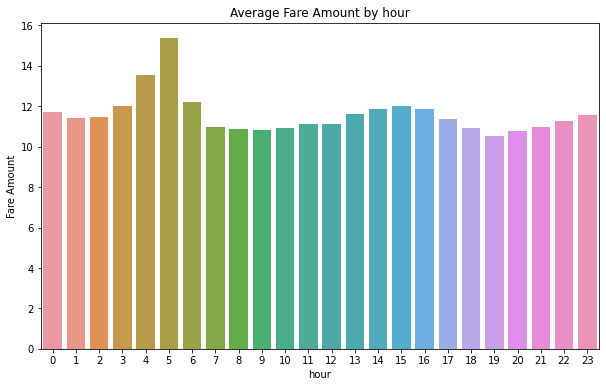

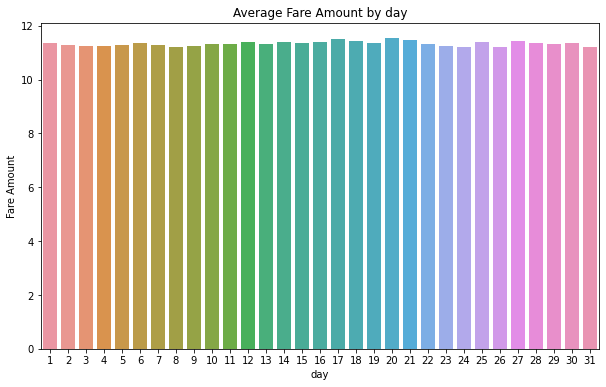

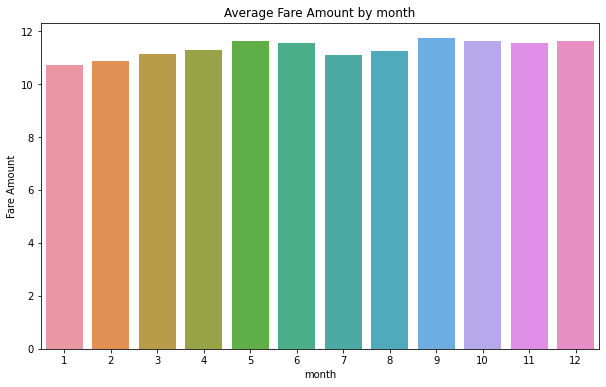

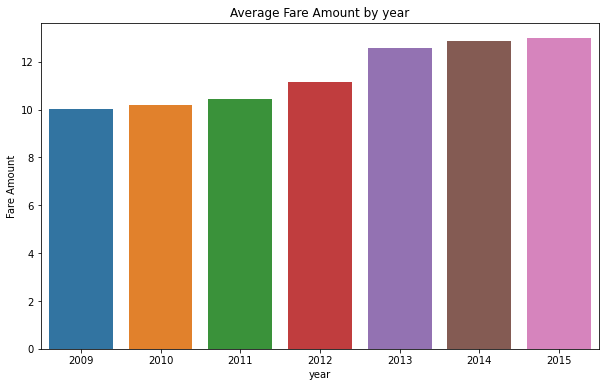

In [37]:
visualize_date_fare(train_df)

In [38]:
def visualize_date_counts(df):
    #     date_objects = ['hour', 'day', 'weekday', 'month', 'year']
    date_objects = ['hour', 'day', 'month', 'year']
    # fig, axes = plt.subplots(1, 5)

    for obj in date_objects:
        plt.figure(figsize=(10,6))
        sns.countplot(x=df[obj])
        plt.ylabel('Count')
        plt.title('Taxi Rides Count by ' + obj)
        plt.show()

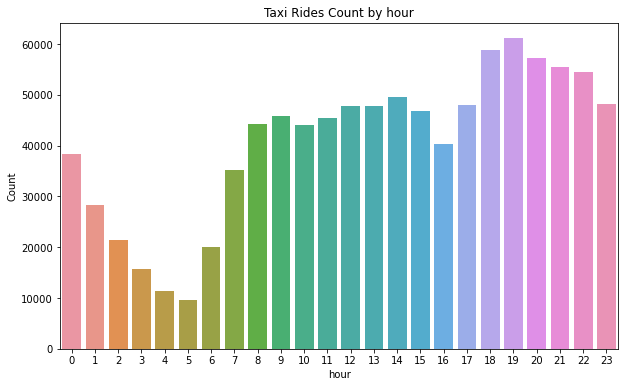

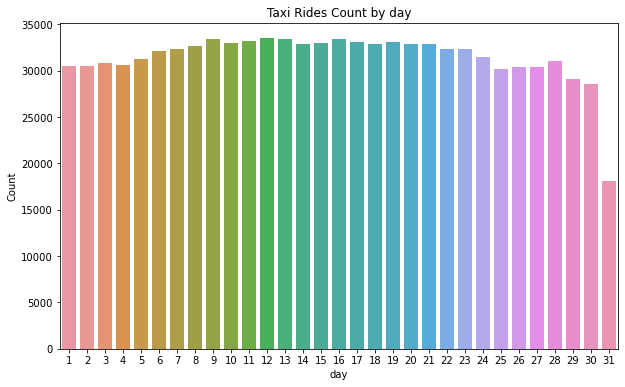

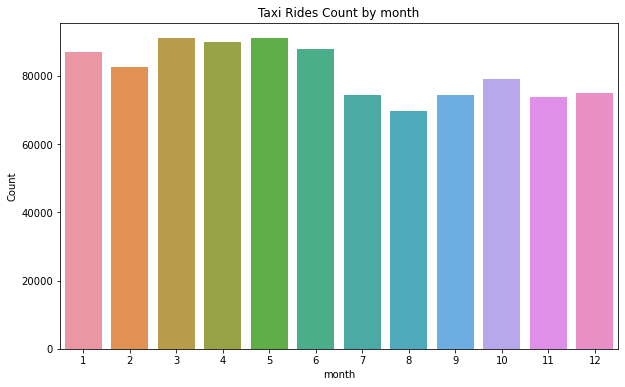

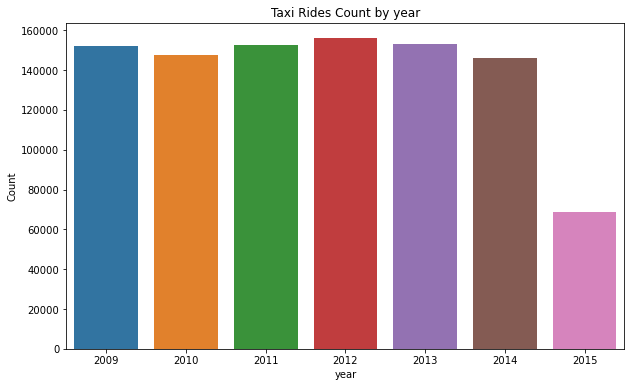

In [39]:
visualize_date_counts(train_df)

In [40]:
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance_to_center,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,long_diff,lat_diff,manhattan_dist
0,4.50000,-73.84431,40.72132,-73.84161,40.71228,1,17,15,6,2009,229.28619,0.13924,0.12750,0.36201,0.35567,0.07437,0.08611,0.00270,-0.00904,0.01174
1,16.90000,-74.01605,40.71130,-73.97927,40.78200,1,16,5,1,2010,229.44791,0.30096,0.33488,0.18026,0.28774,0.20474,0.12127,0.03678,0.07070,0.10748
2,5.70000,-73.98274,40.76127,-73.99124,40.75056,2,0,18,8,2011,229.46456,0.31762,0.31542,0.26353,0.24432,0.12147,0.14068,-0.00850,-0.01071,0.01921
3,7.70000,-73.98713,40.73314,-73.99157,40.75809,1,4,21,4,2012,229.44083,0.29388,0.32327,0.23101,0.25152,0.15399,0.13348,-0.00444,0.02495,0.02939
4,5.30000,-73.96810,40.76801,-73.95665,40.78376,1,7,9,3,2010,229.45666,0.30971,0.31403,0.28491,0.31211,0.10009,0.10042,0.01144,0.01575,0.02719


In [41]:
# X = train_df.drop(['fare_amount', 'passenger_count'], axis=1)
# y = train_df['fare_amount']

X = train_df.drop(['fare_amount'], axis=1)
y = train_df['fare_amount']

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.05)

In [43]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance_to_center,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,long_diff,lat_diff,manhattan_dist
60687,-73.98395,40.76208,-73.99861,40.72323,1,20,16,5,2009,229.46659,0.31964,0.29545,0.26312,0.20962,0.12188,0.17538,-0.01466,-0.03885,0.05350
623739,-73.78510,40.64860,-73.99240,40.74520,3,14,14,7,2011,229.15426,0.00731,0.31121,0.43130,0.23780,0.20630,0.14720,-0.20730,0.09660,0.30390
265157,-73.99954,40.72671,-73.98411,40.68037,1,17,8,9,2012,229.44680,0.29986,0.23810,0.21217,0.20051,0.17283,0.20374,0.01542,-0.04634,0.06176
678931,-74.01007,40.72058,-74.00748,40.73291,1,22,31,8,2010,229.45120,0.30426,0.31400,0.19551,0.21044,0.18949,0.17456,0.00259,0.01234,0.01493
457599,-73.95446,40.76729,-73.98003,40.73945,1,10,28,7,2012,229.44231,0.29536,0.29309,0.29782,0.24442,0.08718,0.14058,-0.02556,-0.02784,0.05340


In [44]:
del(X)
del(y)

In [47]:
from sklearn.ensemble import RandomForestRegressor

reg_model = Pipeline((
         ("standard_scaler", StandardScaler()),
         ("lin_reg", RandomForestRegressor(max_depth=2, random_state=42, n_jobs=-1, verbose=True, n_estimators=100)),
     ))
reg_model.fit(X_train, y_train)

y_train_pred = reg_model.predict(X_train)
y_val_pred = reg_model.predict(X_val)

print("Random Forest Train RMSE: ", np.sqrt(mse(y_train, y_train_pred)))
print("Random Forest Validation RMSE: ", np.sqrt(mse(y_val, y_val_pred)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


Random Forest Train RMSE:  5.360711373583524
Random Forest Validation RMSE:  5.57404607316172


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [48]:
def XGBoost(X_train,X_test,y_train,y_test):
    dtrain = xgb.DMatrix(X_train,label=y_train)
    dtest = xgb.DMatrix(X_test,label=y_test)

    return xgb.train(params={'objective':'reg:linear','eval_metric':'rmse', 'max_depth':7, 'colsample_bytree':0.9, 'gamma':1}
                    ,dtrain=dtrain,num_boost_round=400, 
                    early_stopping_rounds=30,evals=[(dtest,'test')])

In [49]:
xgb_model = XGBoost(X_train, X_val, y_train, y_val)

[22:27:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:10.68200
[1]	test-rmse:8.08937
[2]	test-rmse:6.42954
[3]	test-rmse:5.40964
[4]	test-rmse:4.80521
[5]	test-rmse:4.46497
[6]	test-rmse:4.25609
[7]	test-rmse:4.12536
[8]	test-rmse:4.06568
[9]	test-rmse:4.01752
[10]	test-rmse:3.98710
[11]	test-rmse:3.95576
[12]	test-rmse:3.95135
[13]	test-rmse:3.94491
[14]	test-rmse:3.93748
[15]	test-rmse:3.91978
[16]	test-rmse:3.90503
[17]	test-rmse:3.88698
[18]	test-rmse:3.88177
[19]	test-rmse:3.87901
[20]	test-rmse:3.87533
[21]	test-rmse:3.86228
[22]	test-rmse:3.84168
[23]	test-rmse:3.83973
[24]	test-rmse:3.83622
[25]	test-rmse:3.83145
[26]	test-rmse:3.82924
[27]	test-rmse:3.82357
[28]	test-rmse:3.82191
[29]	test-rmse:3.81995
[30]	test-rmse:3.81839
[31]	test-rmse:3.81493
[32]	test-rmse:3.81203
[33]	test-rmse:3.80707
[34]	test-rmse:3.80288
[35]	test-rmse:3.79942
[36]

In [50]:
y_train_pred = xgb_model.predict(xgb.DMatrix(X_train), ntree_limit = xgb_model.best_iteration)
y_val_pred = xgb_model.predict(xgb.DMatrix(X_val), ntree_limit = xgb_model.best_iteration)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [51]:
print("Train set error: ", np.sqrt(mse(y_train, y_train_pred)))
print("Validation set error: ", np.sqrt(mse(y_val, y_val_pred)))

Train set error:  2.9872710857083367
Validation set error:  3.734059274961482


In [57]:
test.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance_to_center,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,long_diff,lat_diff,manhattan_dist
0,2015-01-27 13:08:24.0000002,-73.97332,40.76381,-73.98143,40.74384,1,13,27,1,2015,229.45768,0.31074,0.29888,0.27549,0.24741,0.10951,0.13759,-0.00811,-0.01997,0.02808
1,2015-01-27 13:08:24.0000003,-73.98686,40.71938,-73.99889,40.73920,1,13,27,1,2015,229.42680,0.27986,0.31170,0.21752,0.22531,0.16748,0.15969,-0.01202,0.01982,0.03184
2,2011-10-08 11:53:44.0000002,-73.98252,40.75126,-73.97965,40.74614,1,11,8,10,2011,229.45434,0.30740,0.29940,0.25374,0.25149,0.13126,0.13351,0.00287,-0.00512,0.00799
3,2012-12-01 21:12:12.0000002,-73.98116,40.76781,-73.99045,40.75164,1,21,1,12,2012,229.46952,0.32258,0.31569,0.27165,0.24619,0.11335,0.13881,-0.00929,-0.01617,0.02546
4,2012-12-01 21:12:12.0000003,-73.96605,40.78977,-73.98856,40.74443,1,21,1,12,2012,229.47638,0.32943,0.30660,0.30873,0.24086,0.11582,0.14414,-0.02252,-0.04535,0.06787


In [59]:
train.drop('key', axis=1, inplace=True)

KeyError: "['key'] not found in axis"

In [65]:
test['manhattan_dist'] = manhattan_dist(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'] , test['dropoff_longitude'])
test_key = test['key']
x_pred = test.drop(columns=['key', 'passenger_count'])
x_pred = test.drop(columns=['key'])



# Predict from test set
prediction = xgb_model.predict(xgb.DMatrix(x_pred))

In [66]:
test.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance_to_center,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,long_diff,lat_diff,manhattan_dist
0,2015-01-27 13:08:24.0000002,-73.97332,40.76381,-73.98143,40.74384,1,13,27,1,2015,229.45768,0.31074,0.29888,0.27549,0.24741,0.10951,0.13759,-0.00811,-0.01997,0.02808
1,2015-01-27 13:08:24.0000003,-73.98686,40.71938,-73.99889,40.73920,1,13,27,1,2015,229.42680,0.27986,0.31170,0.21752,0.22531,0.16748,0.15969,-0.01202,0.01982,0.03184
2,2011-10-08 11:53:44.0000002,-73.98252,40.75126,-73.97965,40.74614,1,11,8,10,2011,229.45434,0.30740,0.29940,0.25374,0.25149,0.13126,0.13351,0.00287,-0.00512,0.00799
3,2012-12-01 21:12:12.0000002,-73.98116,40.76781,-73.99045,40.75164,1,21,1,12,2012,229.46952,0.32258,0.31569,0.27165,0.24619,0.11335,0.13881,-0.00929,-0.01617,0.02546
4,2012-12-01 21:12:12.0000003,-73.96605,40.78977,-73.98856,40.74443,1,21,1,12,2012,229.47638,0.32943,0.30660,0.30873,0.24086,0.11582,0.14414,-0.02252,-0.04535,0.06787


In [67]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.50000,2009-06-15 17:26:21+00:00,-73.84431,40.72132,-73.84161,40.71228,1
1,16.90000,2010-01-05 16:52:16+00:00,-74.01605,40.71130,-73.97927,40.78200,1
2,5.70000,2011-08-18 00:35:00+00:00,-73.98274,40.76127,-73.99124,40.75056,2
3,7.70000,2012-04-21 04:30:42+00:00,-73.98713,40.73314,-73.99157,40.75809,1
4,5.30000,2010-03-09 07:51:00+00:00,-73.96810,40.76801,-73.95665,40.78376,1


In [68]:
len(x_pred)

9914

In [69]:
prediction = prediction.round(2)

In [70]:
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction
})

submission.to_csv('submission.csv',index=False)

In [71]:
pd.read_csv('submission.csv').head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.89000
1,2015-01-27 13:08:24.0000003,10.54000
2,2011-10-08 11:53:44.0000002,4.71000
3,2012-12-01 21:12:12.0000002,7.98000
4,2012-12-01 21:12:12.0000003,15.25000


Plotting Feature Importance


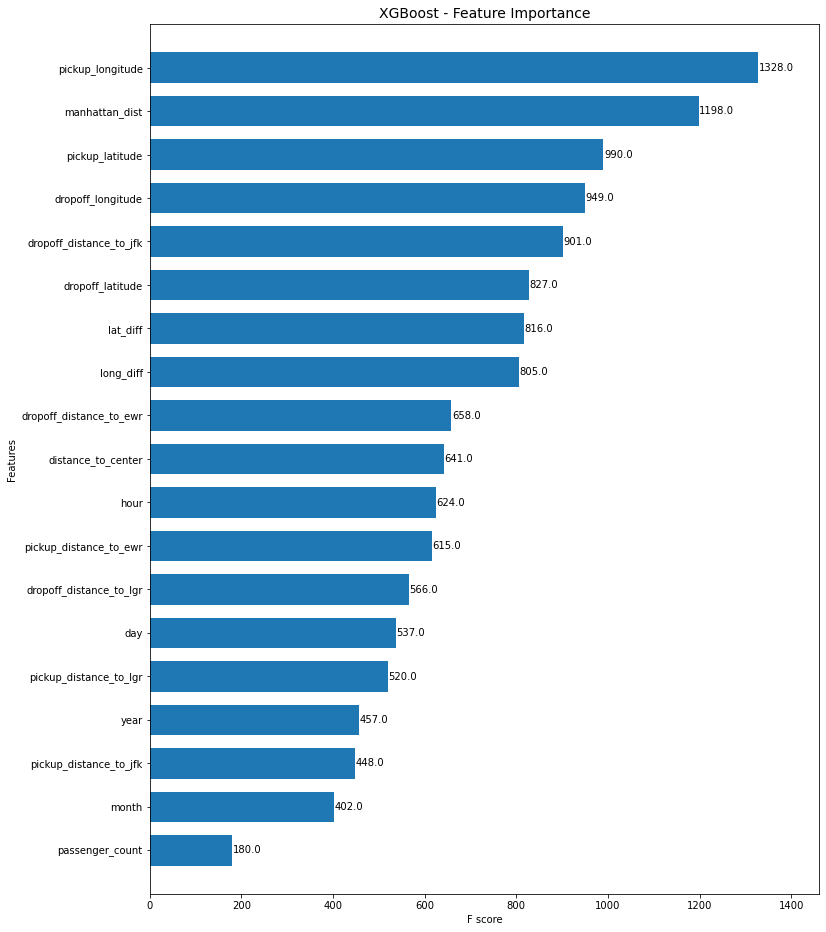

In [72]:
print('Plotting Feature Importance')
fig, ax = plt.subplots(figsize=(12,16))
xgb.plot_importance(xgb_model, height=0.7, ax=ax)
ax.grid(False)
plt.title("XGBoost - Feature Importance", fontsize=14)
plt.show()

In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [102]:
parameters = {'xg__learning_rate':  [0.03, 0.05], # learning rate decides what percentage
                                                  #  of error is to be fitted by
                                                  #   by next boosted tree.
                                                  # See this answer in stackoverflow:
                                                  # https://stats.stackexchange.com/questions/354484/why-does-xgboost-have-a-learning-rate
                                                  # Coefficients of boosted trees decide,
                                                  #  in the overall model or scheme, how much importance
                                                  #   each boosted tree shall have. Values of these
                                                  #    Coefficients are calculated by modeling
                                                  #     algorithm and unlike learning rate are
                                                  #      not hyperparameters. These Coefficients
                                                  #       get adjusted by l1 and l2 parameters
              'xg__n_estimators':   [200,  300],  # Number of boosted trees to fit
                                                  # l1 and l2 specifications will change
                                                  # the values of coeff of boosted trees
                                                  # but not their numbers

              'xg__max_depth':      [4,6],
              'pca__n_components' : [15,21],
              'xg__booster': ['gbtree','gblinear']
              }                               # Total: 2 * 2 * 2 * 2


In [103]:
parameters = {'xg__learning_rate':  [0.03, 0.05], # learning rate decides what percentage
                                                  #  of error is to be fitted by
                                                  #   by next boosted tree.
                                                  # See this answer in stackoverflow:
                                                  # https://stats.stackexchange.com/questions/354484/why-does-xgboost-have-a-learning-rate
                                                  # Coefficients of boosted trees decide,
                                                  #  in the overall model or scheme, how much importance
                                                  #   each boosted tree shall have. Values of these
                                                  #    Coefficients are calculated by modeling
                                                  #     algorithm and unlike learning rate are
                                                  #      not hyperparameters. These Coefficients
                                                  #       get adjusted by l1 and l2 parameters
               'xg__max_depth':      [4,6],
 
              'pca__n_components' : [15,21],
               }                               # Total: 2 * 2 * 2 * 2



In [113]:
from xgboost.sklearn import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as ss
steps_xg = [('sts', ss() ),
            ('pca', PCA()),
            ('xg',  XGBClassifier(silent = False,
                                  n_jobs=3)        # Specify other parameters here
            )
            ]
pipe_xg = Pipeline(steps_xg)
pipe_xg.get_params()
clf = GridSearchCV(pipe_xg,            # pipeline object
                   parameters,         # possible parameters
                   n_jobs = 2,         # USe parallel cpu threads
                   cv =2 ,             # No of folds
                   verbose =1,         # Higher the value, more the verbosity
                   scoring = ['accuracy', 'roc_auc'],  # Metrics for performance
                   refit = 'roc_auc'   # Refitting final model on what parameters?
                                       # Those which maximise auc
                   )



In [117]:
import time
import os
import gc
import random
print("\n\n--Takes time...---\n")
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
print()
(end - start)/60     
del X
del data
del y
gc.collect()



--Takes time...---

Fitting 2 folds for each of 8 candidates, totalling 16 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 2019 2020 2021], got [1.0000e-02 2.5000e+00 2.5100e+00 ... 1.9858e+02 1.9950e+02 2.0000e+02]